<a href="https://colab.research.google.com/jessegrabowski/spartan-stats-tutomrial-2025/blob/main/notebooks/02_causal_inference.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**💡 To better engage gray mass we suggest you turn off Colab AI autocompletion in `Tools > Settings > AI Assistance`**

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import graphviz as gr
import pymc as pm
import arviz as az
import preliz as pz

# Set a random seed for reproducibility
seed = sum(map(ord, 'Spartan Intro to Causality'))
rng = np.random.default_rng(seed)

# Inference and Causality

So far we've just been playing with generating data. As you can see, this is a very useful exercise! We were able to refine our model down to something more or less reasonable. This is the first part of the **modern Bayesian workflow**, which goes something like:

1. Write down a model that you think might explain data you're interested in
2. Without looking at any data, sample from this model and look at what you get.
3. Critically examine the generated data. Refine the model to patch grevious problems in the model
4. Loop 1-3 until you are satisfied that the model makes "reasonable" outputs
5. Show the model data and do inference
6. Analyze the outputs
7. Go back to step 1, adding complexity to your model.
8. Repeat 1-7 until you are satisfied

So far we've done steps 1-4. In this notebook, we want to extend our workflow across all 8 steps.

# Causal Graphs

Since we have to cover a lot of conceptual steps, let's restrict our attention to a very simple example: estimating the weight of a person. This example comes to us by way of Richard McElreath's incredible book Statistical Rethinking, and the associated youtube lectures ([lecture](https://www.youtube.com/watch?v=tNOu-SEacNU), [PyMC implementation](https://www.pymc.io/projects/examples/en/latest/statistical_rethinking_lectures/03-Geocentric_Models.html)).

In the last notebook, we started with some algebra. In this notebook, we are going to start with a *causal DAG*. A DAG is a Directed Acyclic Graph -- a graph (in the network sense) with no loops, where there is a notion of ordering. A causal DAG is a tool for organizing scientific thinking. In a causual DAG, a variable points to another variable if it *causes* it. 

For example, when thinking about height, we can say that **height** points to **weight**, because the taller you are, the more person there is. We cannot, on the other hand, credibly say that weight points to height! So the causal DAG will look like this:

In [2]:
def draw_causal_graph(edge_list, node_props=None, edge_props=None, graph_direction="UD"):
    """Utility to draw a causal (directed) graph"""
    g = gr.Digraph(graph_attr={"rankdir": graph_direction})

    edge_props = {} if edge_props is None else edge_props
    for e in edge_list:
        props = edge_props[e] if e in edge_props else {}
        g.edge(e[0], e[1], **props)

    if node_props is not None:
        for name, props in node_props.items():
            g.node(name=name, **props)
    return g

Here we've also included a second determinant of weight, __unobserved factors__. This is everything else that we can't see about an individual -- age, sex, race, other genetic factors, health and nutrition, etc. These all plausably have an effect on weight, but we assume two things:

1. They have no causal connect with height (terrible assumption!)
2. The variations in these factors "wash out" -- that is, **jointly**, we assume they could cause weight to be higher or lower.  (maybe ok?)

Drawing a graph like this is important because it pulls out the _scientific_ assumptions about the data we're looking at. We see already that we are making some bad assumptions! But part of the Bayesian workflow is to slow build up from a simple model, making sure that we're doing the right thing.

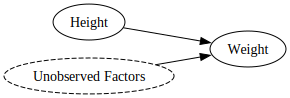

In [3]:
draw_causal_graph(
    edge_list=[("Height", "Weight"), ("Unobserved Factors", "Weight")],
    node_props={"Unobserved Factors": {"style": "dashed"}},
    graph_direction="LR",
)

One very important point: drawing the above graph does **not** imply any specific functional form on the relationship between variables, but it **does** imply that some functional relationship exists! We can read the above graph as saying that:

$$ W_i = f(H_i, U_i) $$

Where the subscript $i$ is indexing individual people. We can read this as saying that "The height of some individual $i$ is a function of her height, and some other stuff we don't observe".

## Download Data

The data come to us by way of Statsitical Rethinking. It gives the height, weight, age, and sex of people from a partial census the [Dobe !Kung people](https://en.wikipedia.org/wiki/%C7%83Kung_people), a foraging population that live mostly in southern Angola and northern Namibia.

In [4]:
data_url = 'https://raw.githubusercontent.com/pymc-devs/pymc-examples/refs/heads/main/examples/statistical_rethinking_lectures/data/Howell1.csv'
df = pd.read_csv(data_url, delimiter=';')
df.head()

,height,weight,age,male
0,151.765,47.825606,63.0,1
1,139.700,36.485807,63.0,0
2,136.525,31.864838,65.0,0
3,156.845,53.041914,41.0,1
4,145.415,41.276872,51.0,0


Looking at the data, we see that there is a non-linear relationship between height and weight, but that this relationship appears to be mediated by age. If we focus on just the adults in the populaton (roughly the green and yellow zone), it looks pretty linear! For the very young (dark purple), it also looks linear, but there's some acceleration that happens around age 15 (gee, what could that be?).

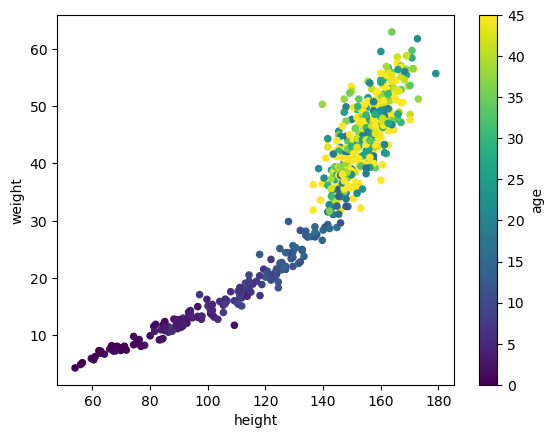

In [5]:
df.plot.scatter(x='height', y='weight', c='age', vmax=45);

For the sake of making the modeling easier, let's start by just considering the adults. Focusing on this, things look very linear. We can move from our general causal structure:

$$ W_i = f(H_i, U_i) $$

To a specific statistical model:

$$ W_i = \alpha + \beta H_i + U_i $$

Again, thinking scientifically, we have some expectations about this:

1. $\alpha$ should be zero. This is because when $H_i = 0$, $\mathbb E[W_i] = 0$. Biologically, we expect that someone with zero height should have zero weight.
2. $\beta$ should be positive. As someone gets taller, there is more person there, so weight should increase.

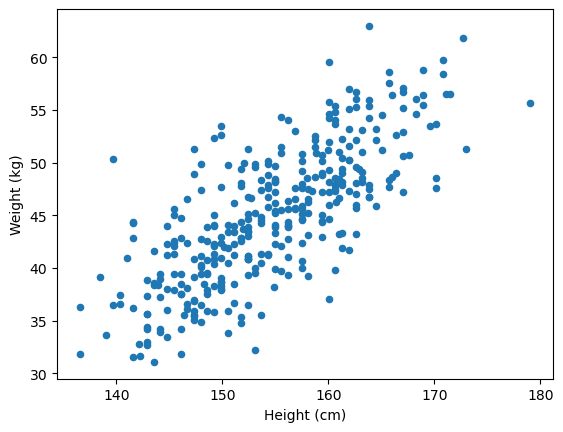

In [6]:
fig, ax = plt.subplots()
adult_df = df.loc[lambda x: x.age >= 18]
adult_df.plot.scatter(x='height', y='weight', ax=ax)
ax.set(xlabel='Height (cm)', ylabel='Weight (kg)')
plt.show()

# Prior Predictive Validation

The loop of looking at priors we did in the first notebook is called *prior predictive sampling*. This is an important firs step in modeling! Before we look at data at all, we want to make a model using plausable artifical data, and make sure that we can recover the answers we know are true.

PyMC offers a number of tools to accomplish this. The most important are `pm.Data` and `pm.observe`:

- `pm.Data` creates a data "container" that we can swap values in and out of, without rewriting the whole model.
- `pm.observe` transforms a model by associating observed data to a random variable. It lets us write a model with no data (like we did in the last notebook), then later inject in data for inference. This is useful because we can first use the model to generate data, then condition on it and make sure we get consistent answers.

Let's see how this all works in practice.

In [7]:
height_min, height_max = adult_df.height.min(), adult_df.height.max()
print(f'Minimum height: {height_min:0.2f}')
print(f'Maximum height: {height_max:0.2f}')

Minimum height: 136.53
Maximum height: 179.07


In [8]:
person_idx = range(adult_df.shape[0])
height_dist = pm.Uniform.dist(130, 200)
height_data = pm.draw(height_dist, len(person_idx))


with pm.Model(coords={'person':person_idx}) as weight_model_1:
    height = pm.Data('height', height_data, dims=['person'])
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Gamma('beta', alpha=2, beta=1)

    expected_weight = alpha + beta * height
    sigma = pm.Exponential('sigma', 1)
    weight_hat = pm.Normal('weight_hat', mu=expected_weight, sigma=sigma, dims=['person'])

    prior = pm.sample_prior_predictive(random_seed=rng)

Sampling: [alpha, beta, sigma, weight_hat]


`sample_prior_predictive` samples from `alpha`, `beta`, and `sigma` many times. For each sample, it constructs a populatiion of weights from the distribution:

$$ W_i \sim N(\alpha + \beta H_i, \sigma) $$

If we look at the `prior` object, we see that we have 500 such populations. Each popuation has 352 people, whose heights were drawn from a $\text{Uniform}(130, 200)$ distribution. Note, though, that these heights were drawn **only once** -- what varies between the different sample populations is only the model parameters.Let's have a look at this whole sample population by making a KDE plot of sample weights

In [9]:
prior

Inference data with groups:
	> prior
	> constant_data

Let's have a look at this whole sample population by making a KDE plot of sample weights. It looks... terrible! We have a long tail of samples where weights go up into the thousands of kilograms. We need to think more carefully about priors.

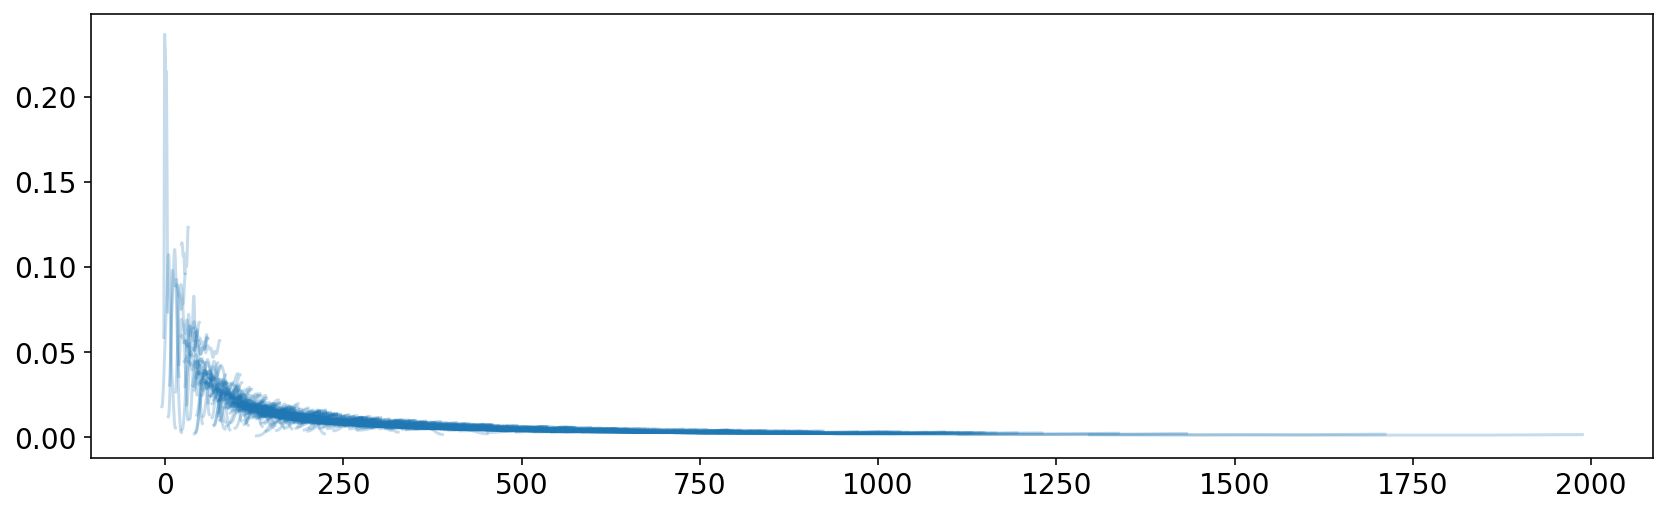

In [10]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
for draw in range(500):
    az.plot_kde(prior.prior.weight_hat.sel(chain=0, draw=draw).values, 
                ax=ax,
                plot_kwargs=dict(alpha=0.25))

In addition to looking at the population distributions we output, we should also look at lines generated by the model. Basically, we should always check our model outputs in the space that makes the most intuitive sense to us! In this case, since we have a 1-d linear model, it makes sense to plot some lines.

Hopefully you agree that some of these slopes are a bit... aggressive. A few are nearly vertical! 

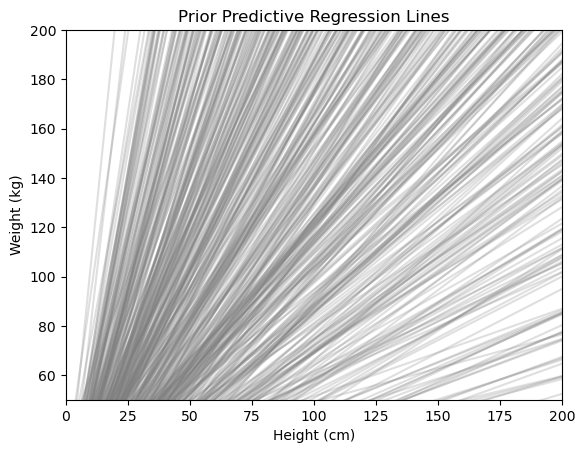

In [11]:
x_grid = np.linspace(0, 200, 100)
fig, ax = plt.subplots()
for idx in range(500):
    alpha = prior.prior.alpha.sel(chain=0, draw=idx).item()
    beta = prior.prior.beta.sel(chain=0, draw=idx).item()
    line = alpha + beta * x_grid
    ax.plot(x_grid, line, color="0.5", alpha=0.25)
ax.set(ylim=(50, 200), xlim=(0, 200), xlabel='Height (cm)', ylabel='Weight (kg)', title='Prior Predictive Regression Lines')
plt.show()

Let's use `preliz` to do some exploration. The most suspicious thing to me is the prior on the $\beta$ parameter. I decided this because I know the Gamma distribution has a long right tail, and is strictly positive. If the issue was in $\alpha$, I'd expect to see people with negative height, since it's cenetered on zero and normal.

/Users/jessegrabowski/mambaforge/envs/spartan-pymc/lib/python3.12/site-packages/numba/np/ufunc/dufunc.py:288: RuntimeWarning: invalid value encountered in nb_logpdf
  return super().__call__(*args, **kws)


<Axes: >

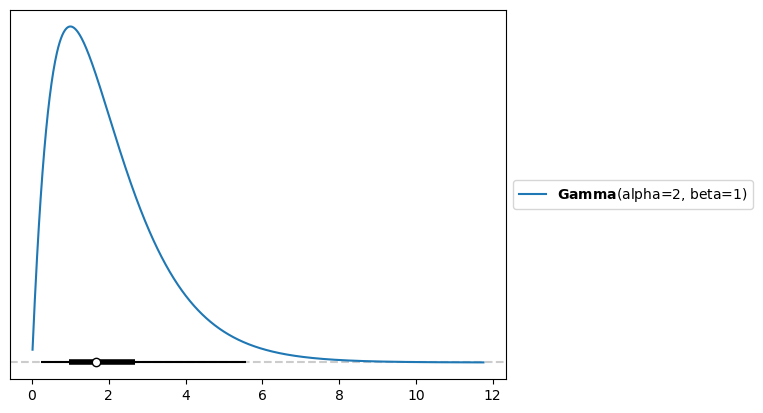

In [12]:
pz.Gamma(alpha=2, beta=1).plot_pdf(pointinterval=True, interval='hdi', levels=[0.5, 0.95])

We read the above plot as follows. The blue hill is showing us the PDF of a Gamma(2, 1) distribution, which we used as a prior on the effect of height on weight. The numbers on the bottom are values of $\beta$ that our distribution covers, and the height of the PDF is how much probability piles up on a given value. The higher the hill, the higher the density of probabiliy we pile onto values in that region.

The box-and-wiskers looking thing at the bottom is giving us the 50% and 95% **highest density intervals** (HDIs) for this distribution. An HDI shows the widest interval such that $n\%$ of the probability mass is included. We can see that the 50% HDI goes from about 1.5 to 2.5, and the 95% HDI goes from just over 0 to almost 6.

Since we're in linear model world, this has an easy intrepretation. Height is measured in centimeters, and weight in kilograms. We're saying that we believe, with 50% confidence, that the weight of extra centimeter is between 1 and 3 kilograms. And with 95% confidence, we believe the weight is between 0 and 5 kilograms. 

I don't know about you, but this seems bonkers to me. I don't much about human biology, but even saying 1 cenimeter of person weights 1 kilogram is nuts.

Let's use `pz.maxent` to get a distribution with 95% of the mass between 0 and say 0.8. It can have some tail beyond that (maybe I'm catastrophically wrong!), but let's constrain ourselves to a more reasonable range.

Evidently, the distribution we want is a Gamma(2.23, 6.12). Let's resample the model with this prior.

(Gamma(alpha=2.23, beta=6.12), <Axes: >)

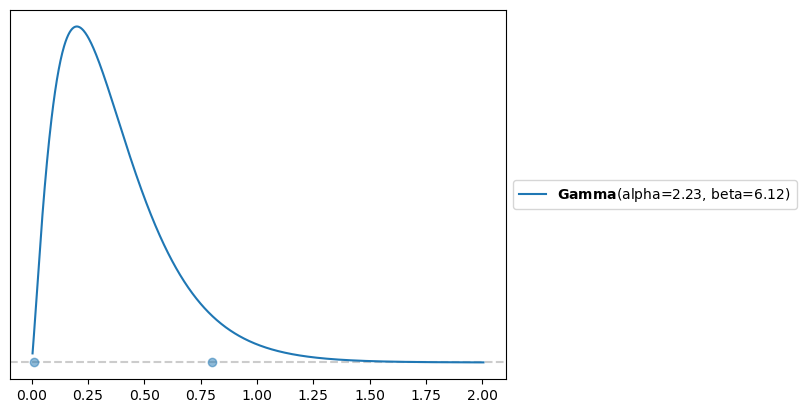

In [13]:
pz.maxent(pz.Gamma(), 0.01, 0.8)

In [14]:
with pm.Model(coords={'person':person_idx}) as weight_model_2:
    height = pm.Data('height', height_data, dims=['person'])
    alpha = pm.Normal('alpha', mu=0, sigma=10)
    beta = pm.Gamma('beta', alpha=2.23, beta=6.12)

    expected_weight = pm.Deterministic('expected_weight', alpha + beta * height, dims=['person'])
    sigma = pm.Exponential('sigma', 1)
    weight_hat = pm.Normal('weight_hat', mu=expected_weight, sigma=sigma, dims=['person'])

    prior = pm.sample_prior_predictive(random_seed=rng)

Sampling: [alpha, beta, sigma, weight_hat]


This still isn't perfect, but it's a lot more reasonable! Now we see we have people with negative weight, but our max is at least biologically plausable (if unhealthy).

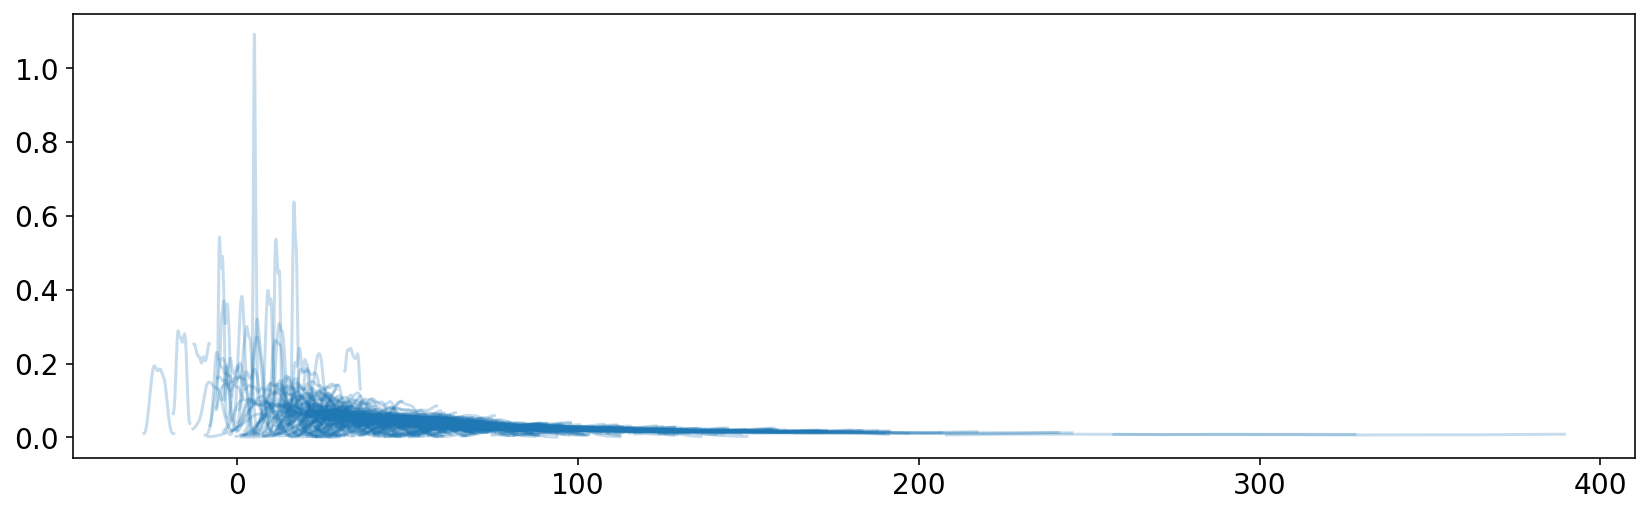

In [15]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
for draw in range(500):
    az.plot_kde(prior.prior.weight_hat.sel(chain=0, draw=draw).values, 
                ax=ax,
                plot_kwargs=dict(alpha=0.25))

Looking in the space of regression lines, we see that the straight vertical lines are (mostly!) eliminated. Most of the lines are pretty chill, and seem to exist in the range of plausable adult human weights (between 50-200 kg)

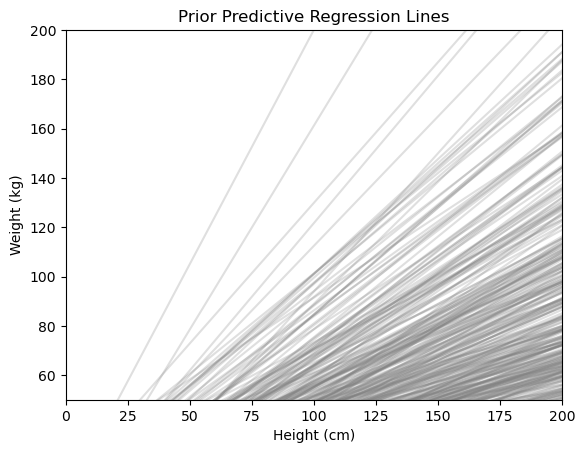

In [16]:
x_grid = np.linspace(0, 200, 100)
fig, ax = plt.subplots()
for idx in range(500):
    alpha = prior.prior.alpha.sel(chain=0, draw=idx).item()
    beta = prior.prior.beta.sel(chain=0, draw=idx).item()
    line = alpha + beta * x_grid
    ax.plot(x_grid, line, color="0.5", alpha=0.25)
ax.set(ylim=(50, 200), xlim=(0, 200), xlabel='Height (cm)', ylabel='Weight (kg)', title='Prior Predictive Regression Lines')
plt.show()

To validate the model, we can choose a sample to be our "truth". Pick your favorite number between 1 and 500, and pull out the associated values from the `prior` object

In [17]:
truth_idx = 123
true_params = prior.prior.sel(chain=0, draw=truth_idx)
weight_data = true_params.weight_hat
true_alpha, true_beta, true_sigma = true_params.alpha.item(), true_params.beta.item(), true_params.sigma.item()

Here's our sample of artifical people. It has less "spread" than the real data, and it sure looks linear!

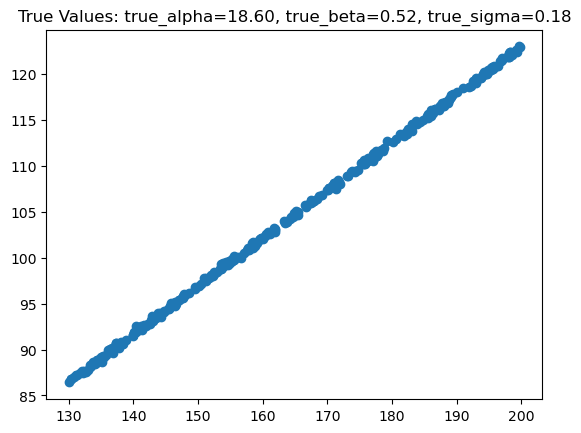

In [18]:
fig, ax = plt.subplots()
ax.scatter(x=height_data, y=weight_data.values)
ax.set_title(f'True Values: {true_alpha=:0.2f}, {true_beta=:0.2f}, {true_sigma=:0.2f}')
plt.show()

## Parameter Recovery 

Now that we have a "ground truth", we want to try to recover it. We are **finally** ready to sample a model.

We will:

1. Inject the `weight_data` into out model as observed values associated with the `weight_hat` distribution
2. Use `pm.sample` to perform Bayesian inference on the model and obtain the **posterior distribution**

In [19]:
weight_model_obs = pm.observe(model=weight_model_2, vars_to_observations={weight_hat:weight_data})
with weight_model_obs:
    idata = pm.sample(random_seed=rng)
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

### Plot marginal posteriors

The purpose of this check is to make sure our proposed model actually works in the best-case scenario. We won't know the real values when we go to the actual data, (and our proposed model is likely not the true data generating process!). But if we can't get the right answer under the absolute best conditions, we probably need to go back to the drawing board.

In this case, we're doing a great job of recovering the values. The posteriors are centered on the true values, and the uncertainty around the parameters is very low. We can say that our model "works".

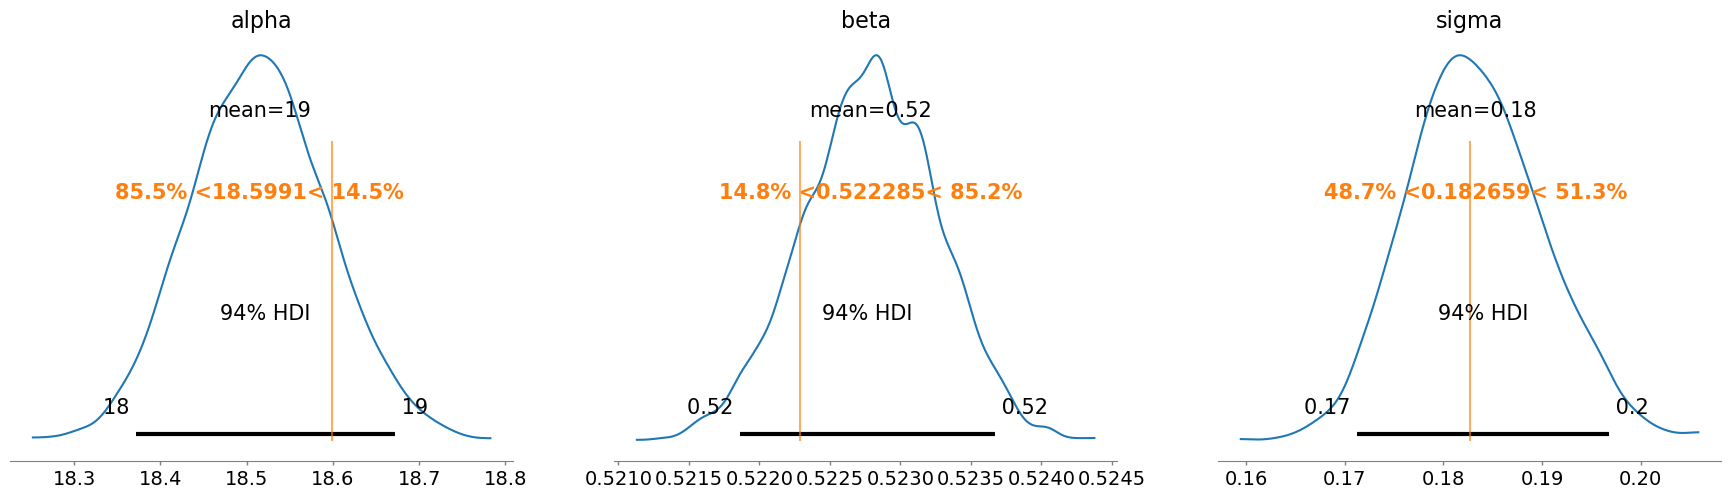

In [20]:
az.plot_posterior(idata, var_names=['alpha', 'beta', 'sigma'], ref_val=[true_alpha, true_beta, true_sigma]);

Well, almost. Parameters are great and all, but we're interested in the "artifical populations" that our model *generates*. We can check that "people" generated by our model look like the sample of data we showed it.

What we want to see here is that the data (the black ribbon) lies inside of the cloud of sampled populations (the blue KDEs). In this case, we're right on the money, so everything is working great.

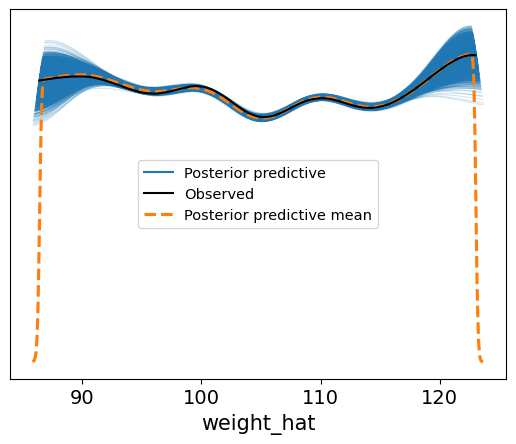

In [21]:
az.plot_ppc(idata);

# Bring in real data!

To add in real data, we can just use `pm.set_data` to re-run our observed model with the real data.

In [22]:
weight_model_real = pm.observe(model=weight_model_2, vars_to_observations={weight_hat:adult_df.weight.values})

with weight_model_real:
    pm.set_data({'height': adult_df.height.values})
    idata = pm.sample(random_seed=rng)
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

### Results and Discussion

There are several things to do when we look at these posteriors:

1. We see that $\beta$ is between 0.5 and 0.62. We interpret this as follows: according to our model, when a person gains 1 additional centimeter of height, we expect that person to gain between 0.5 and 0.6 kilograms of weight.
2. $\alpha$ is very negative! This disagrees with our biological intuition, and suggests that weight is not actually a linear function of height. This was obvious from looking at the full dataset, which included children. In our case, it means that our model does not generalize beyond adult data (since there are no adults with heights close to zero in our dataset).

array([<Axes: title={'center': 'alpha'}>,
       <Axes: title={'center': 'beta'}>,
       <Axes: title={'center': 'sigma'}>], dtype=object)

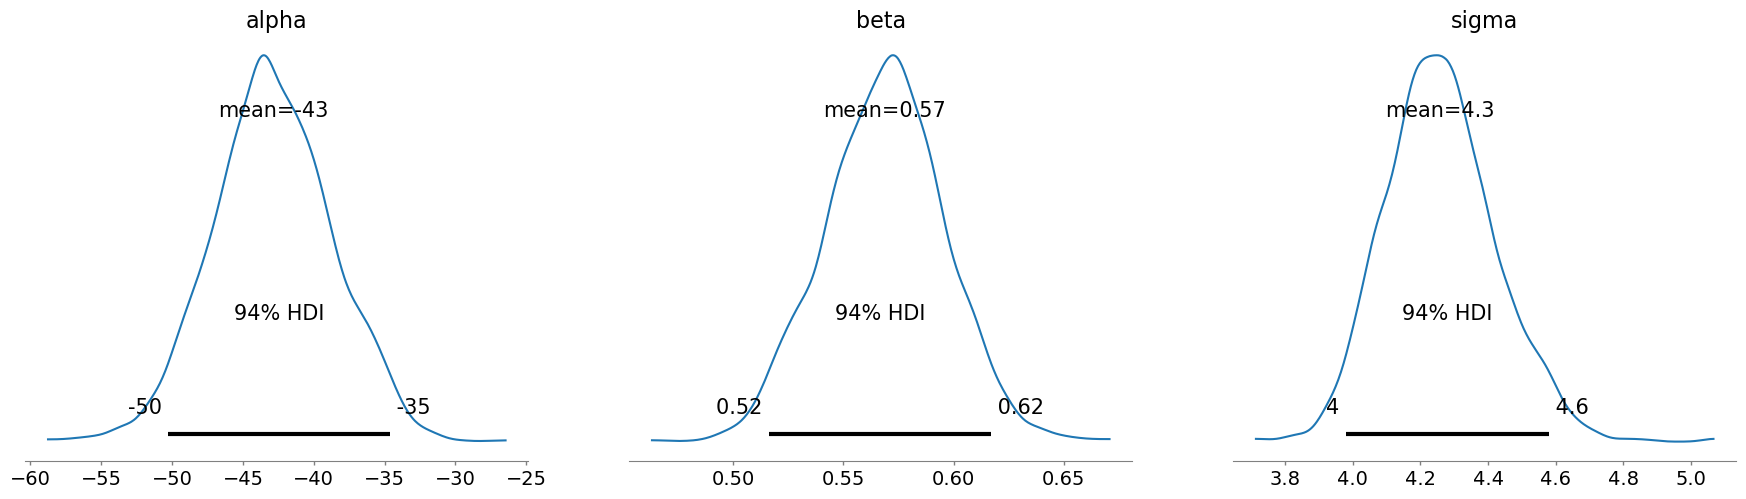

In [23]:
az.plot_posterior(idata, var_names=['alpha', 'beta', 'sigma'])

Generating populations of artifical people, we see that these populations largely resemble the data. So despite our model being abiological, it's not totally off the mark. McElreath calls these models "geocentric", because they do a good job of explaining the data, while entirely ignoring the underlying science.  

<Axes: xlabel='weight_hat'>

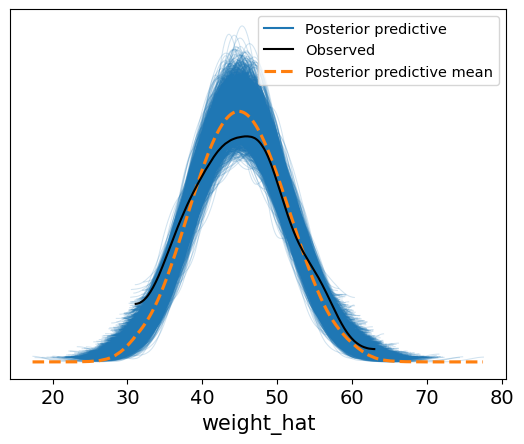

In [24]:
az.plot_ppc(idata)

Finally, we can look at the model outputs in the data space. This means computing HDIs for the regression lines (the `expected_weight` variable in our model), and over the sample populations (the `weight_hat` variable). 

There's not much to say here -- it looks like a linear regression. There's a lot of dispersion from the mean lines, but that is to be expected. 95% of the data appears to lie within the 95% credible interval generated by the model, which means it is in some sense "well calibrated". 

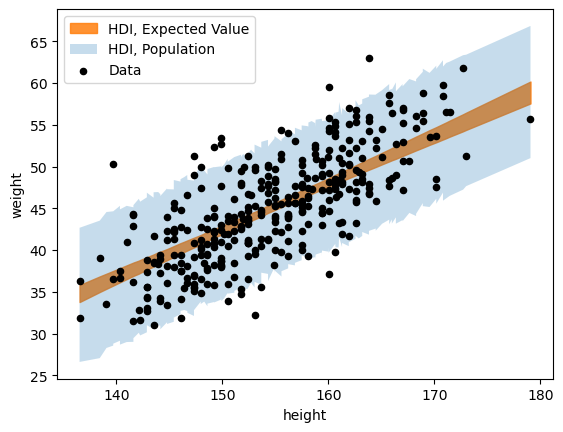

In [25]:
fig, ax = plt.subplots()

mu_hdi = az.hdi(idata.posterior.expected_weight).expected_weight
ppc_hdi = az.hdi(idata.posterior_predictive).weight_hat

sorted_idx = np.argsort(adult_df.height.values)
sorted_height = adult_df.height.values[sorted_idx]

ax.fill_between(sorted_height, 
                *mu_hdi.values[sorted_idx, :].T,
                alpha=0.85,
                color='tab:orange',
                label='HDI, Expected Value')

ax.fill_between(sorted_height, 
                *ppc_hdi.values[sorted_idx, :].T,
                alpha=0.25,
                label='HDI, Population')

adult_df.plot.scatter(x='height', y='weight', ax=ax, c='k', label='Data')
ax.legend()
plt.show()

# Salt-N-Peppa Lyrics Go Here

So we've now seen all the steps from 1-8, although I admittedly did a bad job of labeling them as we went along. The next step is to iterate towards a more complex model that we are interested in drawing scientific conclusions from. 

The heart of the Jueda Pearl school of causal modeling is **interventions**. We want to use our (potentially very complex!) models to do artifical experiments, and see what the results come out to be. 

When the models are very simple, we don't (strictly speaking) need to do these interventions -- we can reason about the model analytically, and come up wth interpretations like "for one additional centimeter of height, we predict a person will gain 0.5 additional kgs of weight".

When models are more complex, this becomes impossible. The point of a causal model is to automatically track all the implications of an intervention like "give someone one additional cm of height" and push out the consequences.

To do this, let's introduce sex into our model. Causually, sex has two implications:

1. Sex has an effect on height
2. Sex has an effect on weight

So we can draw the following DAG:

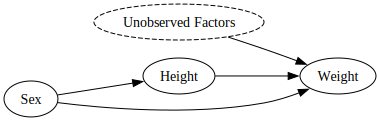

In [26]:
draw_causal_graph(
    edge_list=[("Height", "Weight"), ("Unobserved Factors", "Weight"), ("Sex", "Height"), ('Sex', 'Weight')],
    node_props={"Unobserved Factors": {"style": "dashed"}},
    graph_direction="LR",
)

Notice that there are two paths from sex to weight! One is direct -- this is the **direct effect** of sex on weight. The other passes through height. The **total effect** of sex on weight will be the direct effect, plus the effect that passes through weight.

There is a so-called "Do-Calculus" that you can perform to figure out what information you need to isolate a causal effect of interest. A cool website to help is [Daggity.net](https://dagitty.net/dags.html#). To learn more, go through the Statistical Rethinking lectures. In this case:

- If we want the *total effect* of sex on weight, we can directly model $W_i = f(S_i, U_i)$
- If we want the *direct effect* of sex on weight, eliminating the arrow from sex into height, we need to add height to the model: $W_i = f(S_i, H_i, U_i)$

Basically, the rule is that when a variable is included in a model, you **erase all paths pointing into the node**. So by including Height, we erase the arrow $\text{Sex} \to \text{Height}$, which erases the indirect effect of sex on weight via height, isolating the direct effect.

## Light EDA

Let's look at adult weights, "stratified" by sex. We see that:

1. The population mean of each group appears to be different (maybe 40 for women and 50 for men)
2. The slope of the regression line for women looks a bit steeper maybe? But they're really close.

If we stick to linear models, it makes sense to first focus on the difference in population mean, but keep the effect of additional height on weight equal between each group.

<Axes: xlabel='height', ylabel='weight'>

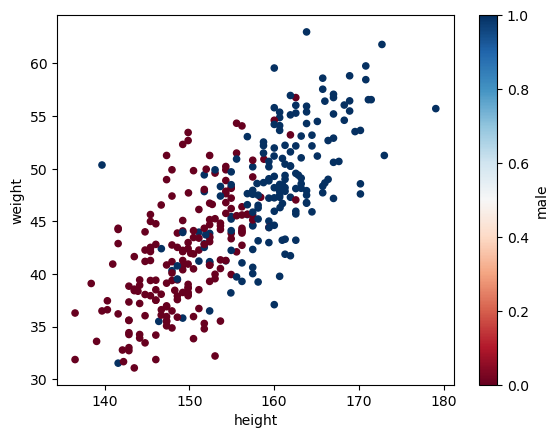

In [27]:
adult_df.plot.scatter(x='height', y='weight', c='male', cmap='RdBu')

## Total Effect

Actually, let's take a step back and focus on the total effect of sex on weight. To do this, according to the DAG we drew, we just need a model:

$$ W_i = f(S_i, U_i) $$

To do this, we can use **Advanced indexing**.

### Sidebar: Advanced indexing in array libraries

Advanced indexing is a way to get numbers out of arrays. Pretty much all tensor/array libraries in python (numpy, pytensor, jax, pytorch, ...) follow the same API.

1. If you have a 1d array (a vector) and you ask for a single index, you will get back a single number
2. If you index a vector with a vector, you make a new vector.

I could type out an explaination, but let's look at an example.

Say I have a length 3 vector of letters:

In [28]:
letters = np.array(['a', 'b', 'c'])
letters

array(['a', 'b', 'c'], dtype='<U1')

I can ask for the letter stored at address `0` as follows:

In [29]:
letters[0]

np.str_('a')

Or, I can make a new vector by passing in a vector of addresses. The length of the new vector will be equal to the length of the index vector. The value at each position will be the address of the index vector

In [30]:
index_vec = np.array([0, 0, 0, 0, 0])
letters[index_vec]

array(['a', 'a', 'a', 'a', 'a'], dtype='<U1')

In [31]:
index_vec = np.array([0, 0, 1, 1, 0])
letters[index_vec]

array(['a', 'a', 'b', 'b', 'a'], dtype='<U1')

In our use case, the *index vector* will be the `is_male` data. We will make a length 2 vector of population means. The mean at address 0 will be associated with women, and the mean at address 1 will be associated with men. Then we can index it with our data. Let's see how this looks with our data

In [32]:
coords = {'person': person_idx, 'sex':['female', 'male']}

with pm.Model(coords=coords) as sex_model:
    height = pm.Data('height', adult_df.height, dims=['person'])
    weight = pm.Data('weight', adult_df.weight, dims=['person'])
    sex_idx = pm.Data('sex_idx', adult_df.male, dims=['person'])

    sex_effect = pm.Normal('sex_effect', mu=10, sigma=10, dims=['sex'])
    expected_weight = pm.Deterministic('expected_weight', sex_effect[sex_idx], dims=['person'])

    sigma = pm.Exponential('sigma', 1)
    weight_hat = pm.Normal('weight_hat', mu=expected_weight, sigma=sigma, observed=weight)

    idata = pm.sample(random_seed=rng)
    idata = pm.sample_posterior_predictive(idata, extend_inferencedata=True, random_seed=rng)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

We estimate one mean for female and male. For variety, I present the results in tabular form. We can see that, on average, men in this sample weight about 7 kg more than women, than the HDIs don't overlap. 

But pictures are way nicer than tables, so let's plot the two posteriors:

In [33]:
az.summary(idata, var_names=['sex_effect', 'sigma'])

,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
sex_effect[female],41.761,0.412,41.024,42.548,0.005,0.007,6684.0,3108.0,1.0
sex_effect[male],48.520,0.414,47.730,49.298,0.005,0.006,6200.0,3231.0,1.0
sigma,5.483,0.208,5.090,5.868,0.003,0.004,6216.0,2835.0,1.0


Plotted this way, we see that there is a lot of daylight between men and women in terms of expected weight! But this does **not** mean that we expect any given man to be heavier than any given women! For this, we need to run an **intervention study**.

Essentially, we want generate a population of only men, then a population of only women, and then compute the difference in height between these populations. This will tell us the population of differences in weights between the sexes.

To do this, we can use `pm.set_data` to counter-factually control the sex of everyone in the population.

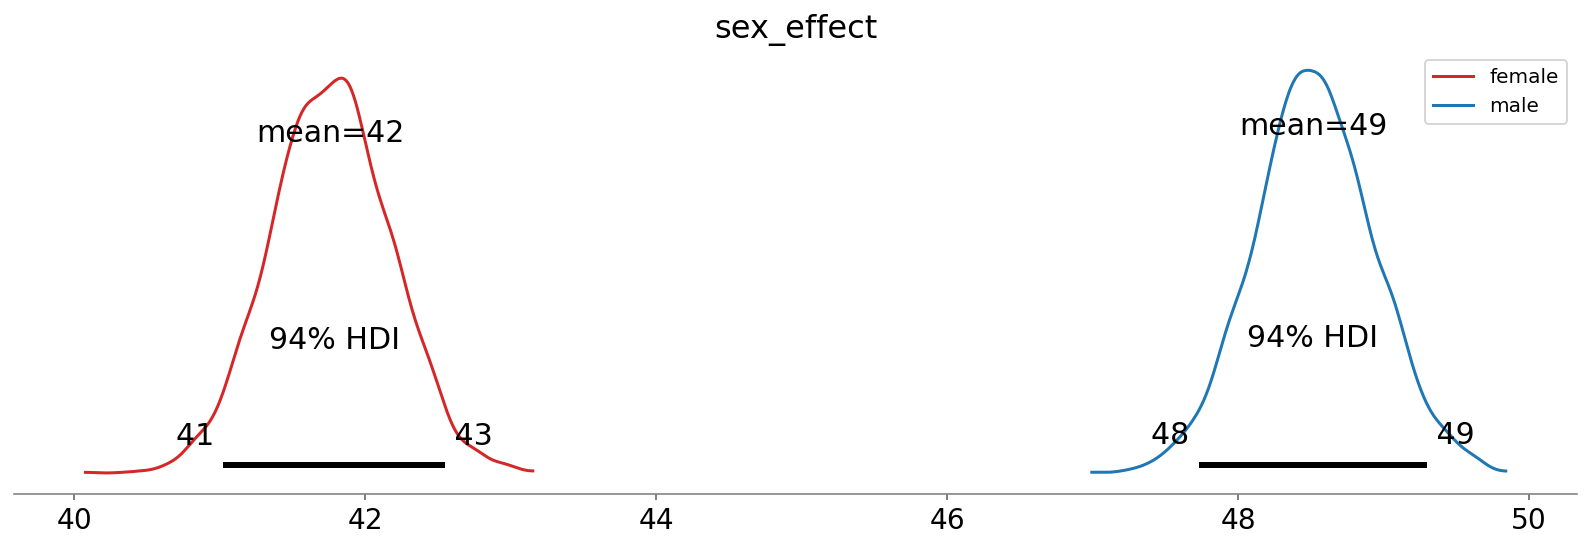

In [34]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
colors = ['tab:red', 'tab:blue']

for sex, color in zip(coords['sex'], colors):
    az.plot_posterior(idata, var_names=['sex_effect'], coords={'sex':sex}, ax=ax, color=color, label=sex)
plt.show()

In [35]:
with sex_model:
    pm.set_data({'sex_idx': np.zeros_like(adult_df.male)})
    female_idata = pm.sample_posterior_predictive(idata, predictions=True, extend_inferencedata=False)

    pm.set_data({'sex_idx': np.ones_like(adult_df.male)})
    male_idata = pm.sample_posterior_predictive(idata, predictions=True, extend_inferencedata=False)

Sampling ... ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 100% 0:00:00 / 0:00:00

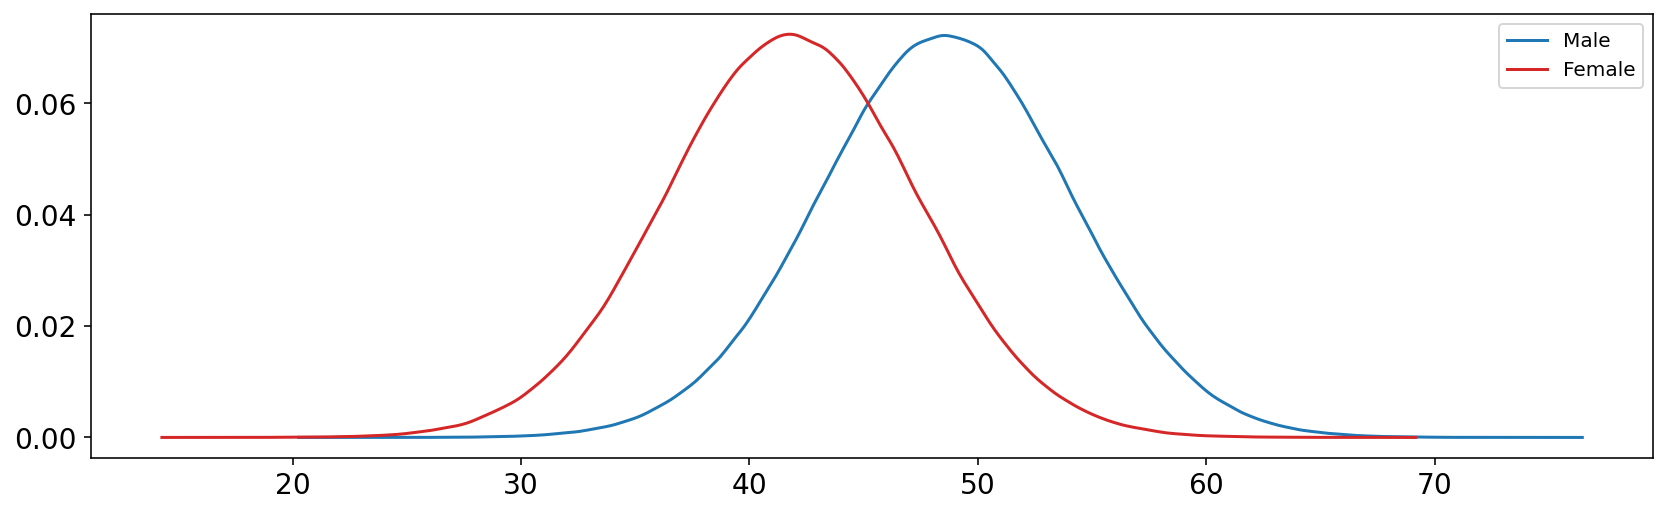

In [36]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
colors = ['tab:red', 'tab:blue']

az.plot_kde(male_idata.predictions.weight_hat.values.ravel(), ax=ax, plot_kwargs=dict(color='tab:blue', label='Male'))
az.plot_kde(female_idata.predictions.weight_hat.values.ravel(), ax=ax, plot_kwargs=dict(color='tab:red', label='Female'))
plt.show()

Some fun (and useful facts):

1. The probability of a certain output in the posterior can be computed using the mean over samples. So if we want to know what the probability of observing a random female who is heavier than a random male, we just compute the proportion of samples in with a negative difference. This ends up being 19%.
2. Notice that even though the **expected value** of weight for men and women has zero overlap, there's a pretty good chance of seeing a woman who is heavier than a man! Perhaps this is counter-intuitive, but it's related to the distribution of weights across the population. **You always have to do the simulation study!**
3. What we computed here is the **total effect** of sex on weight. So we're including the channel that passes through height. If we wanted to isolate only the effect of sex on weight while blocking the causal pathway $\text{Sex} \to \text{Height} \to \text{Weight}$, we need to re-run the analysis including height. This is left as an exercise for the motivated reader. As a sanity check, you should find that the direct effect is smaller than the total effect.

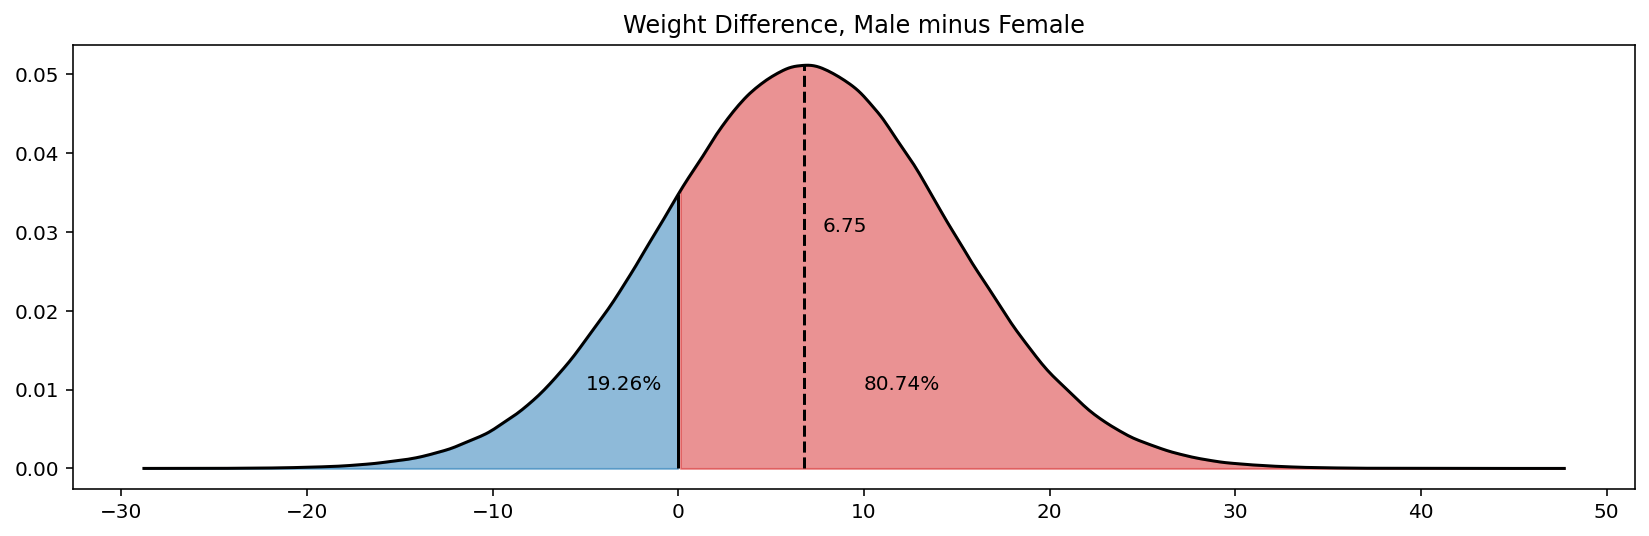

In [37]:
fig, ax = plt.subplots(figsize=(14, 4), dpi=144)
colors = ['tab:red', 'tab:blue']

sex_diff = (male_idata.predictions - female_idata.predictions)
avg_diff = sex_diff.weight_hat.mean().item()
x_kde, y_kde = az.kde(sex_diff.weight_hat.values.ravel())

ax.plot(x_kde, y_kde, color='k')
ax.set_title('Weight Difference, Male minus Female')
ax.fill_between(x_kde, 0, y_kde, where=x_kde < 0, color='tab:blue', alpha=0.5)
ax.fill_between(x_kde, 0, y_kde, where=x_kde > 0, color='tab:red', alpha=0.5)
ax.vlines(0, 0, np.interp(0, x_kde, y_kde), color='k')
ax.vlines(avg_diff, 0, np.interp(avg_diff, x_kde, y_kde), color='k', ls='--')

p_negative = (sex_diff.weight_hat < 0).mean()
p_positive = (sex_diff.weight_hat >= 0).mean()

ax.text(-5, 0.01, f'{p_negative:0.2%}')
ax.text(10, 0.01, f'{p_positive:0.2%}')
ax.text(avg_diff + 1, 0.03, f'{avg_diff:0.2f}')

plt.show()